# Анализ тарифов компании «Мегалайн»

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей

2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей
    
**Тариф «Ультра»**

1. Ежемесячная плата: 1950 рублей

2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей
    
    
**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

# Описание данных

**Таблица** `users` (информация о пользователях):

`user_id` — уникальный идентификатор пользователя

`first_name` — имя пользователя

`last_name` — фамилия пользователя

`age` — возраст пользователя (годы)

`reg_date` — дата подключения тарифа (день, месяц, год)

`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

`city` — город проживания пользователя

`tarif` — название тарифного плана

**Таблица** `calls` (информация о звонках):

`id` — уникальный номер звонка

`call_date` — дата звонка

`duration` — длительность звонка в минутах

`user_id` — идентификатор пользователя, сделавшего звонок

**Таблица** `messages` (информация о сообщениях):

`id` — уникальный номер сообщения

`message_date` — дата сообщения

`user_id` — идентификатор пользователя, отправившего сообщение

**Таблица** `internet` (информация об интернет-сессиях):

`id` — уникальный номер сессии

`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)

`session_date` — дата интернет-сессии

`user_id` — идентификатор пользователя

**Таблица** `tariffs` (информация о тарифах):

`tariff_name` — название тарифа

`rub_monthly_fee` — ежемесячная абонентская плата в рублях

`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату

`messages_included` — количество сообщений в месяц, включённых в абонентскую плату

`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета

`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

# Шаг 1. Обзор данных

Перед началом работы импортируем нужные библиотеки и прочитаем файлы с данными, посмотрим общую информацию о них и проверим на наличие дубликатов.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# чтение файлов и просмотр таблиц
users = pd.read_csv('/datasets/users.csv', sep = ',')
calls = pd.read_csv('/datasets/calls.csv', sep = ',')
messages = pd.read_csv('/datasets/messages.csv', sep = ',')
internet = pd.read_csv('/datasets/internet.csv', sep = ',')
tariffs = pd.read_csv('/datasets/tariffs.csv', sep = ',')

In [3]:
# таблица с пользователями
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
# общая информация
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [5]:
# проверка дубликатов
users.duplicated().sum()

0

В данной таблице:

* столбцы `churn_date` и `reg_date` должны иметь тип `datetime`;
* есть много пропущенных значений в столбце `churn_date`, но это нормально: если значение пропущено, то тариф еще действовал на момент выгрузки данных.

In [6]:
# таблица со звонками
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [7]:
# общая информация
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [8]:
# проверка дубликатов
calls.duplicated().sum()

0

В данной таблице:

* столбец `call_date` должен иметь тип `datetime`;
* есть звонки с нулевой продолжительностью (`duration`) - это пропущенные звонки, удалять не будем.

In [9]:
# таблица с сообщениями
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
# общая информация
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
# проверка дубликатов
messages.duplicated().sum()

0

В данной таблице столбец `message_date` должен иметь тип `datetime`.

In [12]:
# таблица с интернет-сессиями
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [13]:
# общая информация
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [14]:
# проверка дубликатов
internet.duplicated().sum()

0

В данной таблице:

* столбец `session_date` должен иметь тип `datetime`;
* столбец `Unnamed: 0` дублирует уже существующие индексы - он некорректен и должен быть удален.

In [15]:
# таблица с тарифами
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [16]:
# общая информация
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [17]:
# проверка дубликатов
tariffs.duplicated().sum()

0

# Вывод №1

Дубликатов в данных нет. С пропущенными значениями работать не нужно. Проблема только с типом данных в столбцах с датами. Исправим это на следующем этапе. 

# Шаг 2. Подготовка данных

На этом этапе нужно:

* привести данные к нужным типам;
* исправить ошибки в данных.

Есть несколько задач. Нужно посчитать для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножить на значение из тарифного плана; прибавить абонентскую плату, соответствующую тарифному плану).

In [18]:
# удаление лишнего столбца
internet.drop('Unnamed: 0', axis = 1, inplace = True)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [19]:
# изменение типа на datetime
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')

Так как будет необходимо считать звонки, минуты, сообщения и интернет-трафик по месяцам, создадим соответствующие столбцы.

In [20]:
# добавление столбцов с месяцами
calls['month'] = calls['call_date'].astype('datetime64[M]')
messages['month'] = messages['message_date'].astype('datetime64[M]')
internet['month'] = internet['session_date'].astype('datetime64[M]')

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Необходимо отразить это в данных.

In [21]:
# округление секунд
calls['rounded_duration'] = np.ceil(calls['duration'])
calls['rounded_duration'] = calls['rounded_duration'].astype(int)

Одна из задач - для каждого пользователя рассчитать количество сделанных звонков и израсходованных минут разговора по месяцам. Для этого нужно создать сводную таблицу и применить функции `count` и `sum`:

In [22]:
# свобная таблица звонков по пользователям и месяцам
pivot_calls = calls.pivot_table(index = ['user_id','month'], values = 'rounded_duration' , aggfunc = ['count','sum'])
pivot_calls.head(10)

count              sum
                   rounded_duration rounded_duration
user_id month                                       
1000    2018-05-01               22              159
        2018-06-01               43              172
        2018-07-01               47              340
        2018-08-01               52              408
        2018-09-01               58              466
        2018-10-01               57              350
        2018-11-01               43              338
        2018-12-01               46              333
1001    2018-11-01               59              430
        2018-12-01               63              414

Таблица готова. Пользователь с номером 1001, например, в ноябре сделал 59 звонков общей длительностью 430 минут.

Следующая задача - посчитать для каждого пользователя количество отправленных сообщений по месяцам. Алгоритм такой же, но считаем только количество без суммы.

In [23]:
# свобная таблица сообщений по пользователям и месяцам
pivot_messages = messages.pivot_table(index = ['user_id','month'], values = 'id', aggfunc = ['count'])
pivot_messages.head(10)

count
                      id
user_id month           
1000    2018-05-01    22
        2018-06-01    60
        2018-07-01    75
        2018-08-01    81
        2018-09-01    57
        2018-10-01    73
        2018-11-01    58
        2018-12-01    70
1002    2018-06-01     4
        2018-07-01    11

Пользователь с номером 1002 в июне 2018 года отправил 4 сообщения.

Теперь считаем объем израсходованного интернет-трафика по месяцам. Выводим сумму трафика.

In [24]:
# округление мегабайт
internet['gb_used'] = np.ceil(internet['mb_used'] / 1024)
internet['gb_used'] = internet['gb_used'].astype(int)
# свобная таблица интернет-трафика по пользователям и месяцам
pivot_internet = internet.pivot_table(index = ['user_id','month'], values = 'gb_used', aggfunc = ['sum'])
pivot_internet.head(10)

sum
                   gb_used
user_id month             
1000    2018-05-01       4
        2018-06-01      49
        2018-07-01      28
        2018-08-01      27
        2018-09-01      26
        2018-10-01      28
        2018-11-01      27
        2018-12-01      19
1001    2018-11-01      47
        2018-12-01      35

Пользователь с номером 1000 в декабре 2018 года использовал 19 ГБ интернет-трафика.

Последняя задача на этом шаге - нужно посчитать помесячную выручку с каждого пользователя:
* вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
* остаток умножить на значение из тарифного плана; 
* прибавить абонентскую плату, соответствующую тарифному плану.

In [25]:
# соединение сгруппированных данных в один датасет
megaline_data = pivot_calls.merge(pivot_messages, 
                                  on = ['user_id','month'], 
                                  how = 'outer').merge(pivot_internet,  
                                                      on = ['user_id','month'], 
                                                      how = 'outer')
# переименование столбцов
megaline_data.columns = ['calls_count', 'calls_minutes', 'messages_count', 'gb_used']
megaline_data.head(10)

calls_count  calls_minutes  messages_count  gb_used
user_id month                                                          
1000    2018-05-01         22.0          159.0            22.0      4.0
        2018-06-01         43.0          172.0            60.0     49.0
        2018-07-01         47.0          340.0            75.0     28.0
        2018-08-01         52.0          408.0            81.0     27.0
        2018-09-01         58.0          466.0            57.0     26.0
        2018-10-01         57.0          350.0            73.0     28.0
        2018-11-01         43.0          338.0            58.0     27.0
        2018-12-01         46.0          333.0            70.0     19.0
1001    2018-11-01         59.0          430.0             NaN     47.0
        2018-12-01         63.0          414.0             NaN     35.0

In [26]:
# отбор данных с идентификаторами пользователей и названиями тарифа
pivot_users = users[['user_id', 'tariff', 'city']]

# датасет для расчета выручки по месяцам и тарифам
megaline_full_data = megaline_data.join(pivot_users.set_index('user_id'), 
                                        on = ['user_id'],
                                        how = 'left').reset_index().fillna(0)
megaline_full_data.head(10)

,user_id,month,calls_count,calls_minutes,messages_count,gb_used,tariff,city
0,1000,2018-05-01,22.0,159.0,22.0,4.0,ultra,Краснодар
1,1000,2018-06-01,43.0,172.0,60.0,49.0,ultra,Краснодар
2,1000,2018-07-01,47.0,340.0,75.0,28.0,ultra,Краснодар
3,1000,2018-08-01,52.0,408.0,81.0,27.0,ultra,Краснодар
4,1000,2018-09-01,58.0,466.0,57.0,26.0,ultra,Краснодар
5,1000,2018-10-01,57.0,350.0,73.0,28.0,ultra,Краснодар
6,1000,2018-11-01,43.0,338.0,58.0,27.0,ultra,Краснодар
7,1000,2018-12-01,46.0,333.0,70.0,19.0,ultra,Краснодар
8,1001,2018-11-01,59.0,430.0,0.0,47.0,smart,Москва
9,1001,2018-12-01,63.0,414.0,0.0,35.0,smart,Москва


Данные подготовлены. Выведем теперь таблицу с тарифами, чтобы была перед глазами, и приступим к расчетам.

**Таблица** `tariffs` (информация о тарифах):

`tariff_name` — название тарифа

`rub_monthly_fee` — ежемесячная абонентская плата в рублях

`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату

`messages_included` — количество сообщений в месяц, включённых в абонентскую плату

`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета

`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [27]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Создадим функции для расчета выручки:

In [28]:
# создание функции для расчета выручки по звонкам
def calls_revenue (data):
    tariff = data['tariff']
    if tariff == 'smart':
        # минуты сверх плана
        minutes_over = data['calls_minutes'] - tariffs.loc[0, 'minutes_included']
        if minutes_over > 0 :
            # абонентская плата за минуты сверх плана
            call_price = tariffs.loc[0, 'rub_monthly_fee'] + minutes_over * tariffs.loc[0, 'rub_per_minute']
        else:
            call_price = tariffs.loc[0, 'rub_monthly_fee']
    elif tariff == 'ultra':
        # минуты сверх плана
        minutes_over = data['calls_minutes'] - tariffs.loc[1, 'minutes_included']
        if minutes_over > 0 :
            # абонентская плата за минуты сверх плана
            call_price = tariffs.loc[1, 'rub_monthly_fee'] + minutes_over * tariffs.loc[1, 'rub_per_minute']
        else:
            call_price = tariffs.loc[1, 'rub_monthly_fee']
    return call_price

In [29]:
# создание функции для расчета выручки по сообщениям
def messages_revenue (data):
    tariff = data['tariff']
    if tariff == 'smart':
        # сообщения сверх плана
        messages_over = data['messages_count'] - tariffs.loc[0, 'messages_included']
        if messages_over > 0 :
            # абонентская плата за сообщения сверх плана
            messages_price = messages_over * tariffs.loc[0, 'rub_per_message']
        else:
            messages_price = 0
    elif tariff == 'ultra':
        # сообщения сверх плана
        messages_over = data['messages_count'] - tariffs.loc[1, 'messages_included']
        if messages_over > 0 :
            # абонентская плата за сообщения сверх плана
            messages_price = messages_over * tariffs.loc[1, 'rub_per_message']
        else:
            messages_price = 0
    return messages_price

In [30]:
# создание функции для расчета выручки по интернет-трафику
def internet_revenue (data):
    tariff = data['tariff']
    if tariff == 'smart':
        # ГБ сверх плана
        internet_over = data['gb_used'] - tariffs.loc[0, 'mb_per_month_included']/1024
        if internet_over > 0 :
            # абонентская плата за ГБ сверх плана
            internet_price = internet_over * tariffs.loc[0, 'rub_per_gb']
        else:
            internet_price = 0
    elif tariff == 'ultra':
        # ГБ сверх плана
        internet_over = data['gb_used'] - tariffs.loc[1, 'mb_per_month_included']/1024
        if internet_over > 0 :
            # абонентская плата за ГБ сверх плана
            internet_price = internet_over * tariffs.loc[1, 'rub_per_gb']
        else:
            internet_price = 0
    return internet_price

In [31]:
# добавление в таблицу с расчетами столбца с помесячной выручкой по звонкам, сообщениям и трафиком интернета
megaline_full_data['month_revenue'] = (megaline_full_data.apply(calls_revenue, axis = 1) +
                                       megaline_full_data.apply(messages_revenue, axis = 1) +
                                       megaline_full_data.apply(internet_revenue, axis = 1))
megaline_full_data.head(15)

,user_id,month,calls_count,calls_minutes,messages_count,gb_used,tariff,city,month_revenue
0,1000,2018-05-01,22.0,159.0,22.0,4.0,ultra,Краснодар,1950.0
1,1000,2018-06-01,43.0,172.0,60.0,49.0,ultra,Краснодар,4800.0
2,1000,2018-07-01,47.0,340.0,75.0,28.0,ultra,Краснодар,1950.0
3,1000,2018-08-01,52.0,408.0,81.0,27.0,ultra,Краснодар,1950.0
4,1000,2018-09-01,58.0,466.0,57.0,26.0,ultra,Краснодар,1950.0
5,1000,2018-10-01,57.0,350.0,73.0,28.0,ultra,Краснодар,1950.0
6,1000,2018-11-01,43.0,338.0,58.0,27.0,ultra,Краснодар,1950.0
7,1000,2018-12-01,46.0,333.0,70.0,19.0,ultra,Краснодар,1950.0
8,1001,2018-11-01,59.0,430.0,0.0,47.0,smart,Москва,6950.0
9,1001,2018-12-01,63.0,414.0,0.0,35.0,smart,Москва,4550.0


Для удобства приведем тип `float` к целочисленному типу. 

In [32]:
megaline_full_data['messages_count'] = megaline_full_data['messages_count'].astype(int)
megaline_full_data['gb_used'] = megaline_full_data['gb_used'].astype(int)
megaline_full_data['month_revenue'] = megaline_full_data['month_revenue'].astype(int)

# Вывод № 2

На данном этапе данные были приведены к нужным типам, добавлены месяцы, секунды округлены до минут, а мегабайты — до гигабайт. Удален лишний столбец, дублирующий индексы.

Для каждого пользователя рассчитаны:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячная выручка с каждого пользователя.

# Шаг 3. Анализ данных

Задачи этого шага:

* ответить на вопрос: сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
* посчитать среднее количество, дисперсию и стандартное отклонение;
* построить гистограммы;
* описать распределения.

In [33]:
# расчет среднего по тарифам и месяцам
stat_megaline = megaline_full_data.groupby(['tariff', 'month']).mean().round().astype(int)
stat_megaline.columns = ['user_id', 'calls_count', 'calls_minutes', 'messages_count', 'gb_used', 'revenue']
stat_megaline = stat_megaline.drop(['user_id', 'calls_count'], axis = 1)
stat_megaline

calls_minutes  messages_count  gb_used  revenue
tariff month                                                      
smart  2018-01-01            204              18       22     2515
       2018-02-01            299              24       30     3879
       2018-03-01            390              32       40     5702
       2018-04-01            367              31       36     4885
       2018-05-01            387              34       41     6002
       2018-06-01            396              33       41     5945
       2018-07-01            408              34       42     6064
       2018-08-01            421              34       43     6408
       2018-09-01            429              34       43     6291
       2018-10-01            426              34       44     6526
       2018-11-01            435              34       44     6616
       2018-12-01            479              36       47     7232
ultra  2018-01-01            428              34       27     2567
       2018-02-01            297              22       24     2919
       2018-03-01            490              32       34     3714
       2018-04-01            458              32       33     3382
       2018-05-01            510              38       38     3804
       2018-06-01            480              42       37     3679
       2018-07-01            546              50       40     3989
       2018-08-01            511              48       38     3871
       2018-09-01            539              52       38     3767
       2018-10-01            558              58       39     3884
       2018-11-01            541              56       39     3860
       2018-12-01            593              61       43     4324

Теперь известно, сколько минут разговора, сколько сообщений и какой объем интернет-трафика использовали клиенты каждого тарифа за отчетный период. Например, пользователи тарифа «Ультра» в декабре в среднем использовали 43 ГБ интернет-трафика, отправили 61 сообщение и говорили по телефону 593 минуты.

Однако данные за начало и конец года различаются довольно сильно. Нужно посчитать среднее значение по каждому тарифу, а также дисперсию и стандартное отклонение. Объединим затем все это в одну таблицу.

In [43]:
smart_new = megaline_full_data.query('tariff == "smart"')
ultra_new = megaline_full_data.query('tariff == "ultra"')

In [44]:
stat_frame = pd.DataFrame(columns = ['parameter', 'mean', 'var', 'std', 'tariff'])

ind = 0
t = ['smart', 'ultra']
for p in ['calls_minutes', 'messages_count', 'gb_used']:
    tariff_ind = 0
    for df in [smart_new, ultra_new]:
        stat_frame.loc[ind, 'parameter'] = p
        stat_frame.loc[ind, 'mean'] = round(df[p].mean(),1)
        stat_frame.loc[ind, 'var'] = round(np.var(df[p], ddof = 1),1)
        stat_frame.loc[ind, 'std'] = round(np.std(df[p], ddof = 1),1)
        stat_frame.loc[ind, 'tariff'] = t[tariff_ind]
        ind +=1
        tariff_ind +=1
stat_frame

,parameter,mean,var,std,tariff
0,calls_minutes,417.9,36219.3,190.3,smart
1,calls_minutes,526.6,100873.6,317.6,ultra
2,messages_count,33.4,796.8,28.2,smart
3,messages_count,49.4,2285.3,47.8,ultra
4,gb_used,42.4,223.3,14.9,smart
5,gb_used,38.2,382.8,19.6,ultra


In [45]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Итак, пользователи тарифа «Смарт» в среднем используют:
* 417 минут разговора - в рамках плана;
* 33 сообщения - в рамках плана;
* 42 ГБ интернет-трафика - план предусматривает 15 ГБ.


Пользователи тарифа «Ультра» в среднем используют:
* 526 минут разговора - в рамках плана;
* 49 сообщений - в рамках плана;
* 38 ГБ интернет-трафика - план предусматривает 30 ГБ.

В среднем, минуты разговора и количество сообщений, включенные в тарифный план, удовлетворяют потребности пользователей, но интернет-трафика недостаточно, часть пользователей его докупает в обоих тарифах. При этом пользователям тарифа «Ультра» нужно меньше трафика, чем пользователям тарифа «Смарт».

Выведем описательную статистику, чтобы понять, как именно распределены данные.

In [46]:
# группировка для вывода статистики
megaline_s = megaline_full_data.query('tariff == "smart"')
megaline_u = megaline_full_data.query('tariff == "ultra"')

In [47]:
# описательная статистика - звонки по тарифу «Смарт»
megaline_s['calls_minutes'].describe()

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: calls_minutes, dtype: float64

In [48]:
# описательная статистика - звонки по тарифу «Ультра»
megaline_u['calls_minutes'].describe()

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: calls_minutes, dtype: float64

Звонки по тарифу «Смарт»:
* среднее = 417 минут разговора - в рамках плана;
* 3-й квартиль равен 545 минутам;
* максимальное значение равно 1435 минутам - превышает 500 минут плана;
* оптимальное количество минут = среднее + 3 стандартных отклонения = 417 + 3 * 190 = 987

Можно сказать, что пользователи тарифа «Смарт» в среднем укладываются в лимит минут разговора, однако было бы хорошо, если бы компания повысила его до 1000 минут.

Звонки по тарифу «Ультра»:
* среднее = 526 минут разговора - в рамках плана;
* 3-й квартиль равен 752 минутам;
* максимальное значение равно 1673 минутам - не превышает 3000 минут плана;
* оптимальное количество минут = среднее + 3 стандартных отклонения = 526 + 3 * 317 = 1477

Пользователи тарифа «Ультра» даже близко не подходят к лимиту минут разговора, поэтому компании рекомендуется снизить его до оптимального значения 1500 минут.

In [49]:
# описательная статистика - сообщения по тарифу «Смарт»
megaline_s['messages_count'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_count, dtype: float64

In [50]:
# описательная статистика - сообщения по тарифу «Ультра»
megaline_u['messages_count'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages_count, dtype: float64

Сообщения по тарифу «Смарт»:
* среднее = 33 сообщения - в рамках плана;
* 3-й квартиль равен 51 сообщению - превышает 50 сообщений плана;
* максимальное значение равно 143 сообщениям;
* оптимальное количество сообщений = среднее + 3 стандартных отклонения = 33 + 3 * 28 = 117

Компании рекомендуется повысить лимит сообщений в тарифе «Смарт» до 150.

Сообщения по тарифу «Ультра»:
* среднее = 43 сообщения - в рамках плана;
* 3-й квартиль равен 53 сообщениям - не превышает 1000 сообщений плана;
* максимальное значение равно 61 сообщению;
* оптимальное количество сообщений = среднее + 3 стандартных отклонения = 43 + 3 * 12 = 79

План в 1000 сообщений слишком большой, компании рекомендуется снизить лимит до 100 сообщений в тарифе «Ультра».

In [51]:
# описательная статистика - интернет-трафик по тарифу «Смарт»
megaline_s['gb_used'].describe()

count    2229.000000
mean       42.418125
std        14.943104
min         0.000000
25%        34.000000
50%        43.000000
75%        52.000000
max       101.000000
Name: gb_used, dtype: float64

In [52]:
# описательная статистика - интернет-трафик по тарифу «Ультра»
megaline_u['gb_used'].describe()

count    985.000000
mean      38.164467
std       19.564656
min        0.000000
25%       23.000000
50%       38.000000
75%       52.000000
max       98.000000
Name: gb_used, dtype: float64

Интернет-трафик по тарифу «Смарт»:
* среднее = 42 ГБ интернет-трафика;
* 3-й квартиль равен 52 ГБ;
* максимальное значение равно 101 ГБ - план предусматривает 15 ГБ;
* оптимальное количество ГБ = среднее + 3 стандартных отклонения = 42 + 3 * 14 = 84

И среднее значение, и 3-й квартиль превышают лимит в 15 ГБ. Компании рекомендуется увеличить интернет-трафик тарифа «Смарт» до 100 ГБ, чтобы пользователям хватало.

Интернет-трафик по тарифу «Ультра»:
* среднее = 38 ГБ интернет-трафика;
* 3-й квартиль равен 52 ГБ;
* максимальное значение равно 98 ГБ - план предусматривает 30 ГБ;
* оптимальное количество ГБ = среднее + 3 стандартных отклонения = 38 + 3 * 19 = 95

Аналогичная ситуация. Лимит трафика тарифа «Ультра» нужно повысить до 100 ГБ.

Теперь нужно построить графики по всем пунктам тарифных планов для обоих тарифов. Начнем с количества минут. Строим графики плотности, поскольку переменные непрерывны, на таких графиках лучше видно распределение.

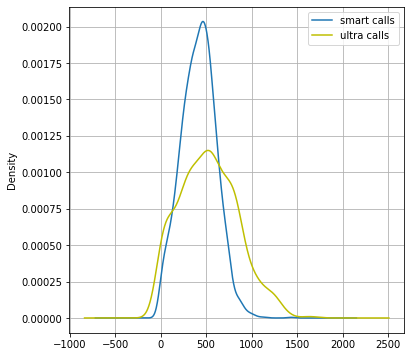

In [53]:
# график для минут разговора
fig, ax = plt.subplots()
smart_new['calls_minutes'].plot(kind = 'density', figsize = (6,6), grid = True,  label = 'smart calls')
ultra_new['calls_minutes'].plot(kind = 'density', figsize = (6,6), grid = True , color = 'y', label = 'ultra calls')
ax.legend()

Графики стремятся к нормальному распределению и немного скошены, график тарифа «Смарт» имеет вытянутую вершину.

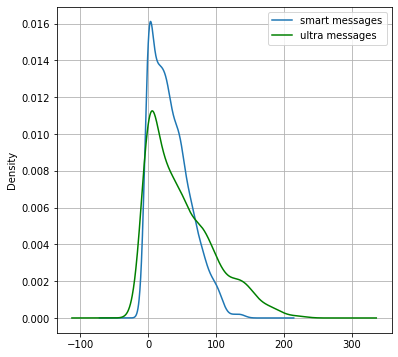

In [54]:
# график для сообщений
fig, ax = plt.subplots()
smart_new['messages_count'].plot(kind = 'density', figsize = (6,6), grid = True, label = 'smart messages')
ultra_new['messages_count'].plot(kind = 'density', figsize = (6,6), grid = True , color ='g', label = 'ultra messages')
ax.legend()

Графики стремятся к нормальному распределению, но имеют очень вытянутые вершины и скошены вправо.

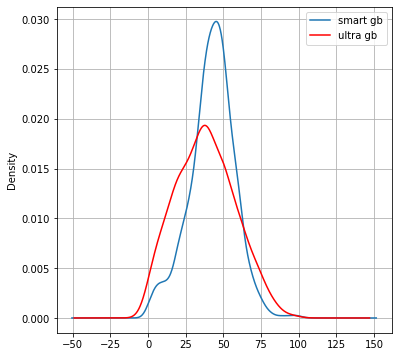

In [55]:
# график для интернет-трафика
fig, ax = plt.subplots()
smart_new['gb_used'].plot(kind = 'density', figsize = (6,6), grid = True, label = 'smart gb')
ultra_new['gb_used'].plot(kind = 'density', figsize = (6,6), grid = True , color = 'r', label = 'ultra gb')
ax.legend()

Графики стремятся к нормальному распределению и скошены влево. График тарифа «Ультра» вытянут сильнее.

# Вывод № 3

На данном этапе было выяснено, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Мы также поработали со статистикой и посчитали среднее количество, дисперсию и стандартное отклонение, построили графики и описали их.

Было установлено, что в среднем минуты разговора и количество сообщений, включенные в тарифный план, удовлетворяют потребности пользователей, но интернет-трафика недостаточно.

Компании рекомендуется:

Тариф «Смарт»:
* повысить лимит минут до 1000;
* повысить лимит сообщений до 150;
* повысить лимит интернет-трафика до 100 ГБ;

Тариф «Ультра»:
* снизить лимит минут до 1500;
* снизить лимит сообщений до 100;
* повысить лимит интернет-трафика до 100 ГБ.

# Шаг 4. Проверка гипотез

Осталась последняя задача - проверка гипотез:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Начнем с первой гипотезы. Посмотрим на выручку по двум тарифам.

In [56]:
# выручка по тарифу «Смарт»
smart_mean_revenue = megaline_full_data.query('tariff == "smart"')
smart_mean_revenue

,user_id,month,calls_count,calls_minutes,messages_count,gb_used,tariff,city,month_revenue
8,1001,2018-11-01,59.0,430.0,0,47,smart,Москва,6950
9,1001,2018-12-01,63.0,414.0,0,35,smart,Москва,4550
10,1002,2018-06-01,15.0,117.0,4,27,smart,Стерлитамак,2950
11,1002,2018-07-01,26.0,214.0,11,45,smart,Стерлитамак,6550
12,1002,2018-08-01,42.0,289.0,13,50,smart,Стерлитамак,7550
...,...,...,...,...,...,...,...,...,...
3208,1489,2018-08-01,0.0,0.0,17,28,smart,Санкт-Петербург,3150
3209,1489,2018-09-01,0.0,0.0,32,50,smart,Санкт-Петербург,7550
3210,1489,2018-10-01,0.0,0.0,21,52,smart,Санкт-Петербург,7950
3211,1489,2018-11-01,0.0,0.0,20,46,smart,Санкт-Петербург,6750


In [57]:
# выручка по тарифу «Ультра»
ultra_mean_revenue = megaline_full_data.query('tariff == "ultra"')
ultra_mean_revenue

,user_id,month,calls_count,calls_minutes,messages_count,gb_used,tariff,city,month_revenue
0,1000,2018-05-01,22.0,159.0,22,4,ultra,Краснодар,1950
1,1000,2018-06-01,43.0,172.0,60,49,ultra,Краснодар,4800
2,1000,2018-07-01,47.0,340.0,75,28,ultra,Краснодар,1950
3,1000,2018-08-01,52.0,408.0,81,27,ultra,Краснодар,1950
4,1000,2018-09-01,58.0,466.0,57,26,ultra,Краснодар,1950
...,...,...,...,...,...,...,...,...,...
3204,1473,2018-09-01,0.0,0.0,19,31,ultra,Красноярск,2100
3205,1473,2018-10-01,0.0,0.0,20,29,ultra,Красноярск,1950
3206,1473,2018-11-01,0.0,0.0,14,40,ultra,Красноярск,3450
3207,1473,2018-12-01,0.0,0.0,20,32,ultra,Красноярск,2250


На первый взгляд данные различаются. Проверим, так ли это на самом деле. Используем метод `st.ttest_ind()`, укажем `equal_var = False`, потому что дисперсии выборок отличаются.

Критический уровень значимости будет равен 0.05 (вероятность правильности вывода 95% и более).

Сформулируем нулевую и альтернативную гипотезы (в нулевой используем знак равенства, альтернативную формируем, отталкиваясь от нулевой):

H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна;

H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [58]:
# проверка гипотезы о равенстве средних двух независимых совокупностей
alpha = 0.05
results = st.ttest_ind(smart_mean_revenue['month_revenue'], ultra_mean_revenue['month_revenue'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()    
print('Средняя выручка в месяц с пользователя тарифа «Смарт»: ', smart_mean_revenue['month_revenue'].mean().round(2))
print('Средняя выручка в месяц с пользователя тарифа «Ультра»: ', ultra_mean_revenue['month_revenue'].mean().round(2))

P-value: 3.366123216919074e-132
Отвергаем нулевую гипотезу

Средняя выручка в месяц с пользователя тарифа «Смарт»:  6247.08
Средняя выручка в месяц с пользователя тарифа «Ультра»:  3844.42


Вывод: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, и по выручке видно, что тариф «Смарт» выгоднее для компании «Мегалайн».

Проверим теперь вторую гипотезу - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сформулируем нулевую и альтернативную гипотезы:

H0 - средняя выручка пользователей из Москвы и других регионов равна;

H1 - средняя выручка пользователей из Москвы и других регионов различается.

In [59]:
# данные по Москве и по другим городам
moscow = megaline_full_data.query('city == "Москва"')
not_moscow = megaline_full_data.query('city != "Москва"')

In [60]:
# проверка гипотезы о равенстве средних двух независимых совокупностей
results = st.ttest_ind(
    moscow['month_revenue'],
    not_moscow['month_revenue']
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()    
print('Средняя выручка в месяц с пользователя из Москвы:', moscow['month_revenue'].mean().round(2))
print('Средняя выручка в месяц с пользователя из другого региона:', not_moscow['month_revenue'].mean().round(2))

p-значение: 0.28336464606572015
Не получилось отвергнуть нулевую гипотезу

Средняя выручка в месяц с пользователя из Москвы: 5397.04
Средняя выручка в месяц с пользователя из другого региона: 5537.42


Вывод: средняя выручка пользователей из Москвы практически не отличается от выручки пользователей из других регионов, можно считать их одинаковыми.

# Вывод № 4

Мы проверили две гипотезы и можем утверждать, что:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, тариф «Смарт» выгоднее для компании «Мегалайн»;
* средняя выручка пользователей из Москвы практически не отличается от выручки пользователей из других регионов, можно считать их одинаковыми.

# Шаг 5. Общий вывод

В результате проделанной работы:
* датасеты с данными о пользователях, количестве и минутах звонков, сообщений и интернет-трафика объединены в один для анализа;
* данные приведены к нужным типам, исправлены ошибки;
* для каждого пользователя рассчитаны количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам, помесячная выручка с каждого пользователя;
* рассчитаны среднее количество, дисперсия и стандартное отклонение;
* даны рекомендации для компании по установлению оптимальных значений лимита по тарифам;
* проверены гипотезы о равенстве выручек по тарифам (тариф «Смарт» выгоднее) и по регионам (разницы нет).